<a href="https://colab.research.google.com/github/JacksonSprigg/DevInterp-MATS-Application/blob/main/RLCT_estimation_and_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RLCT Estimation in MNIST (Task and Model variation)


Hello Jesse and/or Daniel!

**Epistemic status:** Still learning, so maybe some things are on the wrong track!

This document is adapted from the mnist.ipynb in the devinterp repo.

Find more about me at - jacksonsprigg.com

### <u>My goal for the 10 hours</u>:
- Set up multiple architectures and watch how complexity changes as they are forced to deal with increasingly noisey training data sets.

### <u>Here's a quick summary of what I did</u>:

- I altered the notebook to work for MLPs, CNNs, and AEs.
- I added noisy training data sets with various levels of degradation.
- I imported some more devinterp tools for chain monitoring.
- I made some functions to experiment with chain monitoring and tried to apply some kind of standard to this process (for both SGLD and SGNHT).
- I mostly focused on keeping code clean and developing my understanding of the RLCT process as this seemed to be the prerequisite for making progress with devinterp (as opposed to blindly making as many test cases as possible and ploughing through compute). As such, I note that automating this process *will* allow others to blindly plough through compute for you. But I understand it is probably very hard.
- I compared RLCT results of an MLP trained on MNIST and a 0.3 noisy MNIST.
- Preliminary results suggest models trained on noisier data sets are more complex - as I think we all would have guessed. But I want to do a few more tests and hone in my process before I make any real comments.


### <u>Below are some disjunct notes containing thoughts, questions and progress tracking</u>:

- Only tuning chain hyperparams to the finished models and looking at their complexity would have left me with better results to share - given time constraints. As it is, I was trying to measure complexity throughout each epoch. I am content with this outcome considering that I deepened my understanding of the RLCT sampling method. My understanding is that the end goal is to use complexity sampling methods throughout the training process.

- Chain health was an empirical setback to confirming results were genuine. It just took so long to establish chain health that I didn't get the chance to try more involved ideas (Yet!).

- Does it make sense to compare model complexity when models have different architectures? Because I was not sure of this, I didn't do it. If it does make sense to do this, then some of my comments in this document may change slightly.

- I spent a large portion of my time using learning coeff trace plots to monitor chain health so I could confirm the accuracy of LC estimation. My understanding of this was that I needed to keep the chains moving until their Ln(w) plateaus but before it goes down again, ensuring that I have probed the correct basin. This was more tedious than originally thought. It involved creating a basic chain health check function that let me zone in on hyper params before committing to analysis of whole model sets. This method still required a lot of visual monitoring. I found that, even with my limited intuition, adjusting chain hyperparams manually was substantially more efficient than even relatively constrained hyperparam sweeps.

- Chains need to be tuned for every model instance, not just the general architecture? There's no fancy trick here? This seems like it could be a big challenge to larger model training. Instead of averaging chains should we have ways of distinguishing when chains are complete? i.e. figuring out when they have left the basin and cutting them off there, as opposed to letting a bunch of them with set travel distances wander. I realise this is a non-trivial task, I am just idea spewing for my own understanding.

- RLCT from SGLD and SGNHT should track pretty closely, so their observed estimation differences gives us information that could be used for automated chain hyperparam tuning. Just need to understand where the differences come from better. Maybe there's other sampling methods that could play into this as well?

- All the models were quite different in how hyperparams for chains needed to be tuned. Gaining enough understanding to efficiently automate this process seems like a worthwhile endeavour to the engineering side of this project. (Note that I am still not up to date with everything going on in the SLT world, so maybe there are some methods I am unaware of. I will be asking discord soon)

- I am in a bit of a rush having just finished exams and discovered MATS with not much time left for applications, but I will be sure to ask the raised questions on discord and continue to learn after this application process is over. I find SLT to be an interesting area of research and will be continuing to learn more about it. Probing the loss landscape for significant landmarks seems intuitively more useful to me (in regard to training aligned models, maybe not assessing if models are aligned) than fMRI type mechanistic interp approaches. It also seems much harder to effectively do, so I guess that's where the trade off comes in.

### Things I would do with more time:

- This notebook hasn't actually been run to get results with good chain health, I ran out of time and colab GPU. I would also want to do some longer epoch training. All that is required is me sitting here playing with params for another hour or two once my gpu allowance is refreshed, so I'll try finish it after the 17th!

- Given that I did this in one sitting, I didn't save trained models, but I will do that next time.

- I only got the chance to run an MLP on normal and 0.3 noise MNIST. All I need is some more time to run my code though! I've already confirmed that it all works well with 2 epoch test runs.

- I would experiment more with elasticity, noise, and diffusion hyperparams on chain health. As it was now, I wanted to limit myself to lr and chain steps to see if I could build up intuition, which I belive I did.

- I should be training the same architectures on the same data multiple times, using averages instead of single runs for more reliable results. Again just a time and GPU constraint of the 10 hour limit and my late application.

- Import some pre-trained models like ResNet or AlexNet and try them out.

- I would really like to play around with RLCT and some small GPTs. I'm also interested in how RLCT interacts with deceptive/mesa-optimastion. But that's for when I've finished my SLT lectures and upskilled a fair bit more. It's also not overly relevant to this MNIST notebook.


## Installs and imports

In [ ]:
%pip install devinterp matplotlib seaborn torchvision -q

In [ ]:
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt import estimate_learning_coeff, plot_learning_coeff_trace, estimate_learning_coeff_with_summary

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]

## Initialise models

### MLP

In [ ]:
def train_one_epoch_mlp(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate_mlp(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

### CNN

In [ ]:
def train_one_epoch_cnn(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate_cnn(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
    return test_loss / len(test_loader)

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### AutoEncoder

In [ ]:
def train_one_epoch_ae(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.view(data.size(0), -1).to(device)
        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate_ae(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1).to(device)
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            test_loss += loss.item()
    return test_loss / len(test_loader)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Linear(in_features=784, out_features=128)
        self.enc2 = nn.Linear(in_features=128, out_features=64)
        self.enc3 = nn.Linear(in_features=64, out_features=32)

        # Decoder
        self.dec1 = nn.Linear(in_features=32, out_features=64)
        self.dec2 = nn.Linear(in_features=64, out_features=128)
        self.dec3 = nn.Linear(in_features=128, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        return x

## Data loaders

In [ ]:
batch_size = 512

# Making a noisy dataset
def add_noise(img):
    noise = torch.randn(img.size()) * 0.3
    noisy_img = img + noise
    return noisy_img.clamp(0, 1)

transform = transforms.Compose([
    ToTensor(),
    add_noise
])

# Load MNIST data with noise
noisy_train_data = datasets.MNIST("../data", train=True, download=True, transform=transform)
noisy_train_loader = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)

# Load train data
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 114395608.73it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42444181.44it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25693968.72it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19419499.25it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
#### ----------- Replace next run ------------ ####

# batch_size = 512

# # Modified add_noise function to accept noise level
# def add_noise(noise_level):
#     def add_noise_inner(img):
#         noise = torch.randn(img.size()) * noise_level
#         noisy_img = img + noise
#         return noisy_img.clamp(0, 1)
#     return add_noise_inner

# # Creating transforms for different noise levels
# transforms_noisy = {level: transforms.Compose([
#                        transforms.ToTensor(),
#                        add_noise(level)
#                    ]) for level in [0.1, 0.2, 0.3, 0.4, 0.5]}

# # Load MNIST data with different levels of noise
# noisy_train_loaders = {}
# for level, transform in transforms_noisy.items():
#     noisy_train_data = datasets.MNIST("../data", train=True, download=True, transform=transform)
#     noisy_train_loaders[level] = DataLoader(noisy_train_data, batch_size=batch_size, shuffle=True)

# # Load train data
# train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# # Load test data
# test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Train Models

In [ ]:
# All trained on the same data so just use same epochs and standard lr for now
# I am aware AE is doing a different task and shouldn't really be grouped with these hyper params
n_epochs = 15
lr = 0.005

### MLP1 - Normal data

In [ ]:
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader
test_loader_using = test_loader

train_losses_mlp1 = []
test_losses_mlp1 = []
models_mlp1 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_mlp(model, train_loader_using, optimizer, criterion)
    test_loss = evaluate_mlp(model, test_loader_using, criterion)
    train_losses_mlp1.append(train_loss)
    test_losses_mlp1.append(test_loss)
    models_mlp1 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

100%|██████████| 118/118 [00:09<00:00, 12.24it/s]


Epoch 1, Train Loss: 1.9488635507680603, Test Loss: 1.1981888294219971


100%|██████████| 118/118 [00:08<00:00, 14.18it/s]


Epoch 2, Train Loss: 0.7446022081678196, Test Loss: 0.5098103240132332


100%|██████████| 118/118 [00:06<00:00, 18.49it/s]


Epoch 3, Train Loss: 0.4560528432918807, Test Loss: 0.3929181836545467


100%|██████████| 118/118 [00:11<00:00, 10.32it/s]


Epoch 4, Train Loss: 0.37920429898520647, Test Loss: 0.3464030459523201


100%|██████████| 118/118 [00:07<00:00, 15.49it/s]


Epoch 5, Train Loss: 0.34139665797100227, Test Loss: 0.32110926061868666


100%|██████████| 118/118 [00:06<00:00, 17.51it/s]


Epoch 6, Train Loss: 0.3181160910654876, Test Loss: 0.30052804201841354


100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch 7, Train Loss: 0.2993921093263869, Test Loss: 0.28551227748394015


100%|██████████| 118/118 [00:07<00:00, 16.67it/s]


Epoch 8, Train Loss: 0.28415034963922986, Test Loss: 0.27304545529186725


100%|██████████| 118/118 [00:08<00:00, 14.20it/s]


Epoch 9, Train Loss: 0.2699331392423581, Test Loss: 0.2596774633973837


100%|██████████| 118/118 [00:06<00:00, 17.98it/s]


Epoch 10, Train Loss: 0.2588029516450429, Test Loss: 0.2503260564059019


100%|██████████| 118/118 [00:07<00:00, 14.94it/s]


Epoch 11, Train Loss: 0.24699055416099094, Test Loss: 0.24006958529353142


100%|██████████| 118/118 [00:07<00:00, 16.43it/s]


Epoch 12, Train Loss: 0.236799026949931, Test Loss: 0.2320615194737911


100%|██████████| 118/118 [00:07<00:00, 15.84it/s]


Epoch 13, Train Loss: 0.22797683197057853, Test Loss: 0.22233189307153226


100%|██████████| 118/118 [00:08<00:00, 14.02it/s]


Epoch 14, Train Loss: 0.21814888172735603, Test Loss: 0.21527417339384555


100%|██████████| 118/118 [00:07<00:00, 16.43it/s]


Epoch 15, Train Loss: 0.20956476960899467, Test Loss: 0.207709189504385


### MLP2 - Noisy data

In [ ]:
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = noisy_train_loader
test_loader_using = test_loader

train_losses_mlp2 = []
test_losses_mlp2 = []
models_mlp2 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_mlp(model, train_loader_using, optimizer, criterion)
    test_loss = evaluate_mlp(model, test_loader_using, criterion)
    train_losses_mlp2.append(train_loss)
    test_losses_mlp2.append(test_loss)
    models_mlp2 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

100%|██████████| 118/118 [00:12<00:00,  9.80it/s]


Epoch 1, Train Loss: 2.1282989615100925, Test Loss: 1.6223865747451782


100%|██████████| 118/118 [00:12<00:00,  9.71it/s]


Epoch 2, Train Loss: 1.0727514164932703, Test Loss: 0.6203444644808769


100%|██████████| 118/118 [00:12<00:00,  9.22it/s]


Epoch 3, Train Loss: 0.5822811922279455, Test Loss: 0.4577011153101921


100%|██████████| 118/118 [00:10<00:00, 11.23it/s]


Epoch 4, Train Loss: 0.4718287753856788, Test Loss: 0.4021629825234413


100%|██████████| 118/118 [00:10<00:00, 10.86it/s]


Epoch 5, Train Loss: 0.42520911587496935, Test Loss: 0.3726001337170601


100%|██████████| 118/118 [00:11<00:00,  9.88it/s]


Epoch 6, Train Loss: 0.40187965964866895, Test Loss: 0.3610659450292587


100%|██████████| 118/118 [00:12<00:00,  9.53it/s]


Epoch 7, Train Loss: 0.38127268295166855, Test Loss: 0.3438316144049168


100%|██████████| 118/118 [00:11<00:00,  9.91it/s]


Epoch 8, Train Loss: 0.3685977895886211, Test Loss: 0.342278553545475


100%|██████████| 118/118 [00:10<00:00, 11.30it/s]


Epoch 9, Train Loss: 0.35791785181578945, Test Loss: 0.3306948885321617


100%|██████████| 118/118 [00:11<00:00, 10.71it/s]


Epoch 10, Train Loss: 0.3494032839849844, Test Loss: 0.324122728407383


100%|██████████| 118/118 [00:11<00:00,  9.85it/s]


Epoch 11, Train Loss: 0.34400855535167757, Test Loss: 0.3174880050122738


100%|██████████| 118/118 [00:11<00:00,  9.87it/s]


Epoch 12, Train Loss: 0.33684927970170975, Test Loss: 0.30664444006979463


100%|██████████| 118/118 [00:12<00:00,  9.79it/s]


Epoch 13, Train Loss: 0.32571124348600033, Test Loss: 0.2918620962649584


100%|██████████| 118/118 [00:10<00:00, 11.27it/s]


Epoch 14, Train Loss: 0.319611029604734, Test Loss: 0.2936108000576496


100%|██████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch 15, Train Loss: 0.31439056588431535, Test Loss: 0.28522693887352946


### CNN1 - Normal data

In [ ]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader
test_loader_using = test_loader

train_losses_cnn1 = []
test_losses_cnn1 = []
models_cnn1 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_cnn(model, train_loader, optimizer, criterion, DEVICE)
    test_loss = evaluate_cnn(model, test_loader, criterion, DEVICE)
    train_losses_cnn1.append(train_loss)
    test_losses_cnn1.append(test_loss)
    models_cnn1.append(copy.deepcopy(model))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


100%|██████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch 1, Train Loss: 1.8417, Test Loss: 0.5963


100%|██████████| 118/118 [00:08<00:00, 13.41it/s]


Epoch 2, Train Loss: 0.4035, Test Loss: 0.3416


100%|██████████| 118/118 [00:06<00:00, 16.98it/s]


Epoch 3, Train Loss: 0.2812, Test Loss: 0.2637


100%|██████████| 118/118 [00:08<00:00, 13.19it/s]


Epoch 4, Train Loss: 0.2212, Test Loss: 0.2132


100%|██████████| 118/118 [00:07<00:00, 15.97it/s]


Epoch 5, Train Loss: 0.1765, Test Loss: 0.1703


100%|██████████| 118/118 [00:08<00:00, 14.64it/s]


Epoch 6, Train Loss: 0.1459, Test Loss: 0.1425


100%|██████████| 118/118 [00:09<00:00, 13.03it/s]


Epoch 7, Train Loss: 0.1234, Test Loss: 0.1095


100%|██████████| 118/118 [00:06<00:00, 17.12it/s]


Epoch 8, Train Loss: 0.1066, Test Loss: 0.1549


100%|██████████| 118/118 [00:08<00:00, 13.27it/s]


Epoch 9, Train Loss: 0.0952, Test Loss: 0.0922


100%|██████████| 118/118 [00:07<00:00, 16.15it/s]


Epoch 10, Train Loss: 0.0848, Test Loss: 0.0836


100%|██████████| 118/118 [00:08<00:00, 14.56it/s]


Epoch 11, Train Loss: 0.0773, Test Loss: 0.0943


100%|██████████| 118/118 [00:08<00:00, 13.79it/s]


Epoch 12, Train Loss: 0.0715, Test Loss: 0.0788


100%|██████████| 118/118 [00:06<00:00, 17.23it/s]


Epoch 13, Train Loss: 0.0659, Test Loss: 0.0745


100%|██████████| 118/118 [00:08<00:00, 13.39it/s]


Epoch 14, Train Loss: 0.0610, Test Loss: 0.0705


100%|██████████| 118/118 [00:07<00:00, 16.67it/s]


Epoch 15, Train Loss: 0.0579, Test Loss: 0.0593


### CNN2 - Noisy data

In [ ]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = noisy_train_loader
test_loader_using = test_loader

train_losses_cnn2 = []
test_losses_cnn2 = []
models_cnn2 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_cnn(model, train_loader, optimizer, criterion, DEVICE)
    test_loss = evaluate_cnn(model, test_loader, criterion, DEVICE)
    train_losses_cnn2.append(train_loss)
    test_losses_cnn2.append(test_loss)
    models_cnn2.append(copy.deepcopy(model))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

100%|██████████| 118/118 [00:08<00:00, 13.92it/s]


Epoch 1, Train Loss: 1.4044, Test Loss: 0.4093


100%|██████████| 118/118 [00:08<00:00, 14.23it/s]


Epoch 2, Train Loss: 0.3316, Test Loss: 0.2726


100%|██████████| 118/118 [00:06<00:00, 17.19it/s]


Epoch 3, Train Loss: 0.2461, Test Loss: 0.2069


100%|██████████| 118/118 [00:08<00:00, 13.30it/s]


Epoch 4, Train Loss: 0.1906, Test Loss: 0.1649


100%|██████████| 118/118 [00:06<00:00, 17.23it/s]


Epoch 5, Train Loss: 0.1544, Test Loss: 0.1414


100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch 6, Train Loss: 0.1267, Test Loss: 0.1111


100%|██████████| 118/118 [00:07<00:00, 15.20it/s]


Epoch 7, Train Loss: 0.1081, Test Loss: 0.1016


100%|██████████| 118/118 [00:07<00:00, 16.14it/s]


Epoch 8, Train Loss: 0.0951, Test Loss: 0.1046


100%|██████████| 118/118 [00:08<00:00, 13.34it/s]


Epoch 9, Train Loss: 0.0849, Test Loss: 0.0964


100%|██████████| 118/118 [00:07<00:00, 16.46it/s]


Epoch 10, Train Loss: 0.0770, Test Loss: 0.0836


100%|██████████| 118/118 [00:08<00:00, 13.50it/s]


Epoch 11, Train Loss: 0.0707, Test Loss: 0.1142


100%|██████████| 118/118 [00:07<00:00, 15.15it/s]


Epoch 12, Train Loss: 0.0656, Test Loss: 0.0617


100%|██████████| 118/118 [00:07<00:00, 16.52it/s]


Epoch 13, Train Loss: 0.0609, Test Loss: 0.0705


100%|██████████| 118/118 [00:08<00:00, 13.38it/s]


Epoch 14, Train Loss: 0.0580, Test Loss: 0.0566


100%|██████████| 118/118 [00:06<00:00, 17.24it/s]


Epoch 15, Train Loss: 0.0543, Test Loss: 0.0591


### AE1 - Normal data

In [ ]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader
test_loader_using = test_loader

train_losses_ae1 = []
test_losses_ae1 = []
models_ae1 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_ae(model, train_loader_using, optimizer, criterion, DEVICE)
    test_loss = evaluate_ae(model, test_loader_using, criterion, DEVICE)
    train_losses_ae1.append(train_loss)
    test_losses_ae1.append(test_loss)
    models_ae1 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


100%|██████████| 118/118 [00:08<00:00, 14.03it/s]


Epoch 1, Train Loss: 0.1070, Test Loss: 0.1081


100%|██████████| 118/118 [00:06<00:00, 17.91it/s]


Epoch 2, Train Loss: 0.1060, Test Loss: 0.1071


100%|██████████| 118/118 [00:07<00:00, 15.10it/s]


Epoch 3, Train Loss: 0.1051, Test Loss: 0.1061


100%|██████████| 118/118 [00:07<00:00, 16.57it/s]


Epoch 4, Train Loss: 0.1041, Test Loss: 0.1051


100%|██████████| 118/118 [00:06<00:00, 17.07it/s]


Epoch 5, Train Loss: 0.1031, Test Loss: 0.1041


100%|██████████| 118/118 [00:10<00:00, 11.46it/s]


Epoch 6, Train Loss: 0.1022, Test Loss: 0.1032


100%|██████████| 118/118 [00:06<00:00, 18.52it/s]


Epoch 7, Train Loss: 0.1012, Test Loss: 0.1022


100%|██████████| 118/118 [00:08<00:00, 13.99it/s]


Epoch 8, Train Loss: 0.1003, Test Loss: 0.1011


100%|██████████| 118/118 [00:06<00:00, 18.29it/s]


Epoch 9, Train Loss: 0.0993, Test Loss: 0.1001


100%|██████████| 118/118 [00:07<00:00, 14.98it/s]


Epoch 10, Train Loss: 0.0982, Test Loss: 0.0990


100%|██████████| 118/118 [00:06<00:00, 16.99it/s]


Epoch 11, Train Loss: 0.0972, Test Loss: 0.0979


100%|██████████| 118/118 [00:07<00:00, 16.10it/s]


Epoch 12, Train Loss: 0.0962, Test Loss: 0.0969


100%|██████████| 118/118 [00:07<00:00, 14.94it/s]


Epoch 13, Train Loss: 0.0951, Test Loss: 0.0958


100%|██████████| 118/118 [00:06<00:00, 18.17it/s]


Epoch 14, Train Loss: 0.0940, Test Loss: 0.0947


100%|██████████| 118/118 [00:08<00:00, 14.18it/s]


Epoch 15, Train Loss: 0.0930, Test Loss: 0.0937


### AE2 - Noisy data

In [ ]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = noisy_train_loader
test_loader_using = test_loader

train_losses_ae2 = []
test_losses_ae2 = []
models_ae2 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_ae(model, train_loader_using, optimizer, criterion, DEVICE)
    test_loss = evaluate_ae(model, test_loader_using, criterion, DEVICE)
    train_losses_ae2.append(train_loss)
    test_losses_ae2.append(test_loss)
    models_ae2 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

100%|██████████| 118/118 [00:10<00:00, 11.12it/s]


Epoch 1, Train Loss: 0.1285, Test Loss: 0.1089


100%|██████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch 2, Train Loss: 0.1274, Test Loss: 0.1081


100%|██████████| 118/118 [00:12<00:00,  9.27it/s]


Epoch 3, Train Loss: 0.1262, Test Loss: 0.1072


100%|██████████| 118/118 [00:16<00:00,  6.98it/s]


Epoch 4, Train Loss: 0.1250, Test Loss: 0.1064


100%|██████████| 118/118 [00:16<00:00,  7.18it/s]


Epoch 5, Train Loss: 0.1238, Test Loss: 0.1054


100%|██████████| 118/118 [00:12<00:00,  9.30it/s]


Epoch 6, Train Loss: 0.1224, Test Loss: 0.1045


100%|██████████| 118/118 [00:11<00:00,  9.97it/s]


Epoch 7, Train Loss: 0.1210, Test Loss: 0.1034


100%|██████████| 118/118 [00:12<00:00,  9.48it/s]


Epoch 8, Train Loss: 0.1196, Test Loss: 0.1024


100%|██████████| 118/118 [00:11<00:00, 10.67it/s]


Epoch 9, Train Loss: 0.1180, Test Loss: 0.1014


100%|██████████| 118/118 [00:09<00:00, 12.10it/s]


Epoch 10, Train Loss: 0.1165, Test Loss: 0.1004


100%|██████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch 11, Train Loss: 0.1149, Test Loss: 0.0994


100%|██████████| 118/118 [00:12<00:00,  9.74it/s]


Epoch 12, Train Loss: 0.1134, Test Loss: 0.0983


100%|██████████| 118/118 [00:12<00:00,  9.56it/s]


Epoch 13, Train Loss: 0.1117, Test Loss: 0.0974


100%|██████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch 14, Train Loss: 0.1102, Test Loss: 0.0965


100%|██████████| 118/118 [00:11<00:00, 10.58it/s]


Epoch 15, Train Loss: 0.1087, Test Loss: 0.0958


## Chain Health checking function

In [ ]:
# I only alter the variables I currently have intutition on.
# Would randomly select more if I were playing with a larger models that took many more epochs to train.
# I know this function can be much simpler, another lazy moment

def chain_health_monitoring(models_rlct, lr, num_chains, num_draws, sampling_method):
    # Randomly select 2 models from the list to check chain health on
    selected_models = random.sample(models_rlct, 2)

    if sampling_method == SGLD:
        for model in selected_models:
            learning_coeff_stats = estimate_learning_coeff_with_summary(
                model,
                loader=train_loader,
                criterion=criterion,
                sampling_method=sampling_method,
                optimizer_kwargs=dict(lr=lr, elasticity=1.0, num_samples=len(train_data)),
                num_chains=num_chains,
                num_draws=num_draws,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=DEVICE,
            )
            trace = learning_coeff_stats.pop("trace")
            plot_learning_coeff_trace(trace)

    elif sampling_method == SGNHT:
        for model in selected_models:
            learning_coeff_stats = estimate_learning_coeff_with_summary(
                model,
                loader=train_loader,
                criterion=criterion,
                sampling_method=sampling_method,
                optimizer_kwargs=dict(lr=lr, diffusion_factor=0.01, num_samples=len(train_data)),
                num_chains=num_chains,
                num_draws=num_draws,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=DEVICE,
            )
            trace = learning_coeff_stats.pop("trace")
            plot_learning_coeff_trace(trace)
            # (Automating this as to not have to look at the plot would be a cool thing you can do Jackson)

## RLCT Estimate function

In [ ]:
def RLCT_estimate(models, train_loader, train_data, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws):
    rlct_estimates_sgnht = []
    rlct_estimates_sgld = []

    for model in models:
        rlct_estimate_sgnht = estimate_learning_coeff(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=sgnht_lr,
                diffusion_factor=0.01,
                num_samples=len(train_data),
            ),
            sampling_method=SGNHT,
            num_chains=sgnht_num_chains,
            num_draws=sgnht_num_draws,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
        )
        rlct_estimate_sgld = estimate_learning_coeff(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=sgld_lr,
                noise_level=1.0,
                elasticity=1.0,
                num_samples=len(train_data),
                temperature="adaptive",
            ),
            sampling_method=SGLD,
            num_chains=sgld_num_chains,
            num_draws=sgld_num_draws,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
        )

        rlct_estimates_sgnht.append(rlct_estimate_sgnht)
        rlct_estimates_sgld.append(rlct_estimate_sgld)
        print(rlct_estimate_sgld, rlct_estimate_sgnht)

    return rlct_estimates_sgld, rlct_estimates_sgnht

## Running Tests (Tune chains until they look healthy and **then** you can run the RLCT Estimate cell)

### MLP1

In [ ]:
models_rlct = models_mlp1
criterion = nn.CrossEntropyLoss()
train_loader_rlct = train_loader
train_data_rlct = train_data

Chain 2: 100%|██████████| 100/100 [00:06<00:00, 14.44it/s]


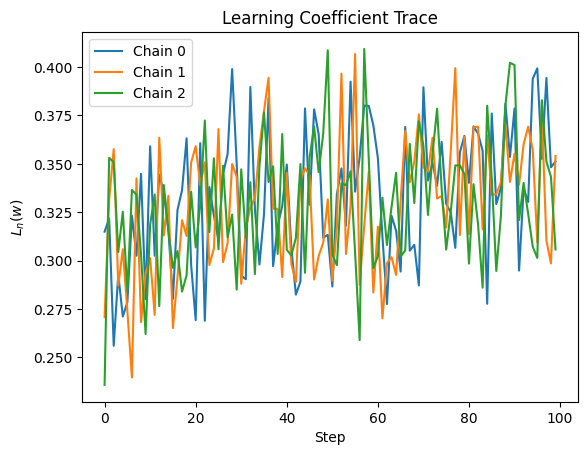

Chain 2: 100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


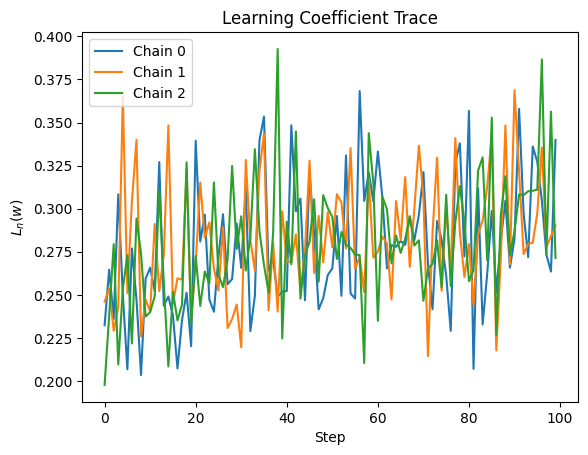

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 100
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 200/200 [00:09<00:00, 21.41it/s] 


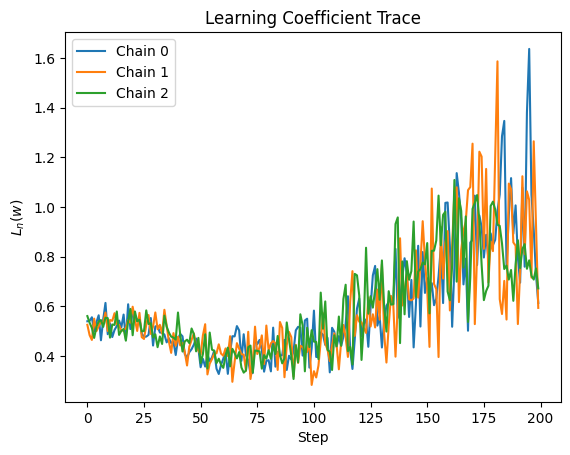

Chain 2: 100%|██████████| 200/200 [00:07<00:00, 25.17it/s] 


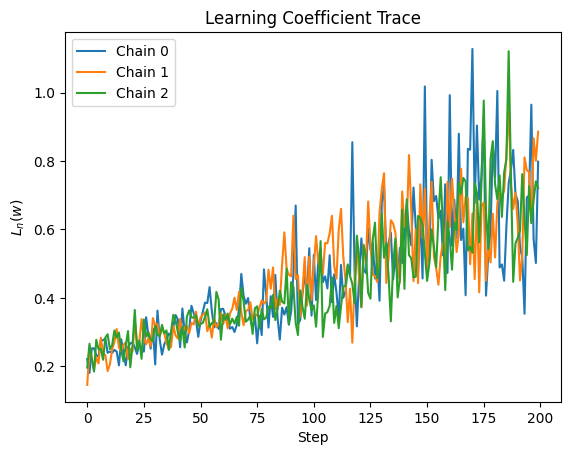

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 1e-6
sgnht_num_chains = 3
sgnht_num_draws = 200
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_mlp1, rlct_estimates_sgnht_mlp1 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

Chain 9: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


-1573.8134591977393 -2748.7219794394023


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


131.20122269017858 470.42763032566893


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


-179.8311967673674 635.2333787212938


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


-106.54241104155415 824.6221670891205


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


40.30159359863382 1118.6390485679074


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


43.49104208183201 878.3458135909782


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.58it/s]


-171.80025143977997 1090.2308649948754


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


138.661376348977 1000.3116281577122


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


-296.34662752591623 1234.5660829257272


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


321.8276848845639 1278.431059306235


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


104.89342355317235 1253.8424620450216


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.91it/s]


17.733505734784156 1073.878610336387


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


164.7446327626613 1325.0284749178616


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


452.31190206039287 1613.8997692823734


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 16.93it/s]

-31.08560876344581 1375.0847400679263


### MLP2

In [ ]:
models_rlct = models_mlp2
criterion = nn.CrossEntropyLoss()
train_loader_rlct = noisy_train_loader
train_data_rlct = noisy_train_data

Chain 2: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


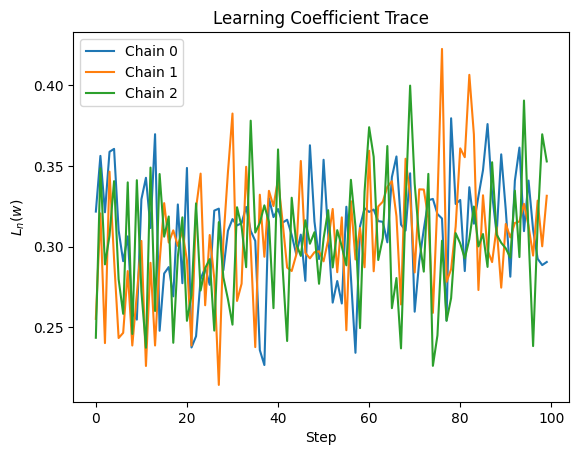

Chain 2: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


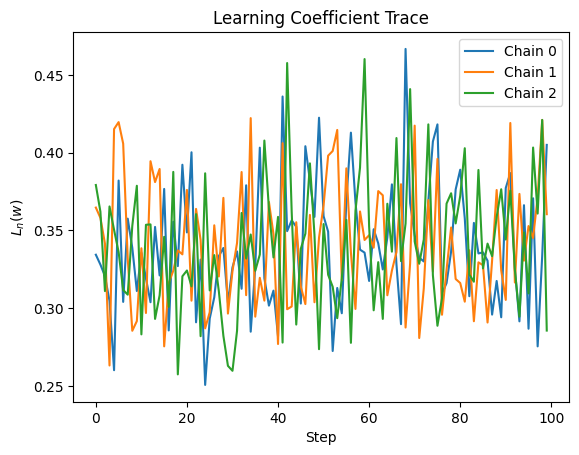

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 100
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 200/200 [00:08<00:00, 23.30it/s] 


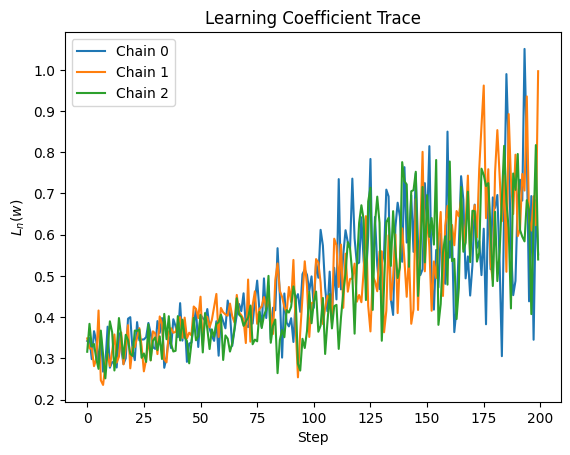

Chain 2: 100%|██████████| 200/200 [00:08<00:00, 22.33it/s] 


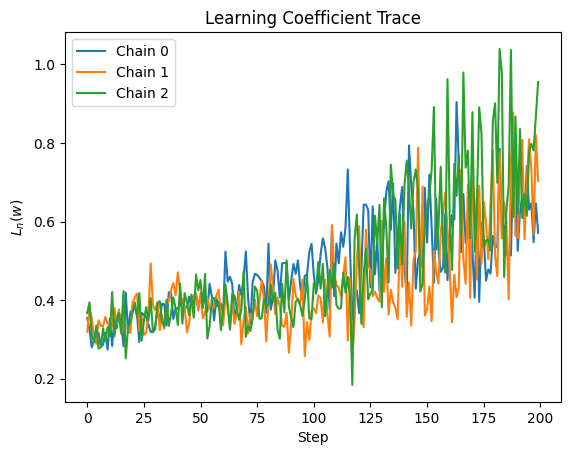

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 1e-6
sgnht_num_chains = 3
sgnht_num_draws = 200
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 3
sgld_num_chains  = 3

rlct_estimates_sgld_mlp2, rlct_estimates_sgnht_mlp2 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


-1978.601256760147 -3292.1354505088166


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


-238.863166747241 872.5314598849678


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


212.47457065016025 2018.1348810873233


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


480.67743387772157 2131.5896044347537


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


97.5324803076767 2069.358699698461


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


66.68515864235252 2061.956274960077


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


-73.42455815349506 1964.344585175742


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


551.4442525155123 2420.770033964404


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


505.0627350682763 2377.309765819461


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


400.78424473068316 2693.866009743822


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


53.80419983381401 2132.0386494663267


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


4.041656659404772 2575.743717165926


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


637.2374214962545 2231.231609255416


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


281.0047737321455 2301.308672917908


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]

439.60421961970235 2231.9582497552806


### CNN1

In [ ]:
models_rlct = models_cnn1
criterion = nn.CrossEntropyLoss()
train_loader_rlct = train_loader
train_data_rlct = train_data

Chain 2: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


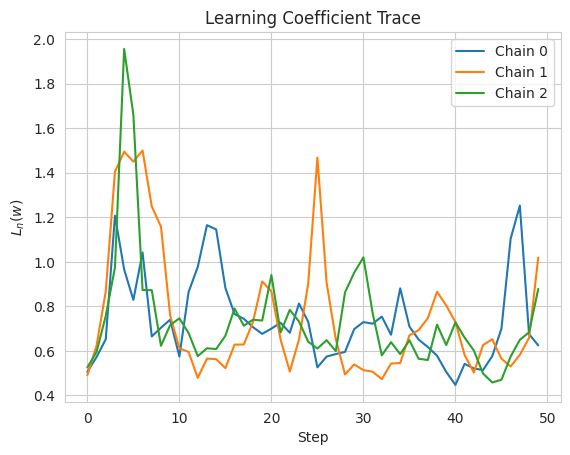

Chain 2: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


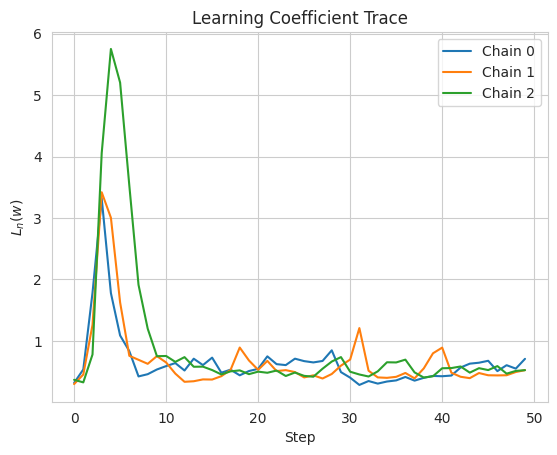

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-7
sgld_num_chains = 3
sgld_num_draws = 50
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


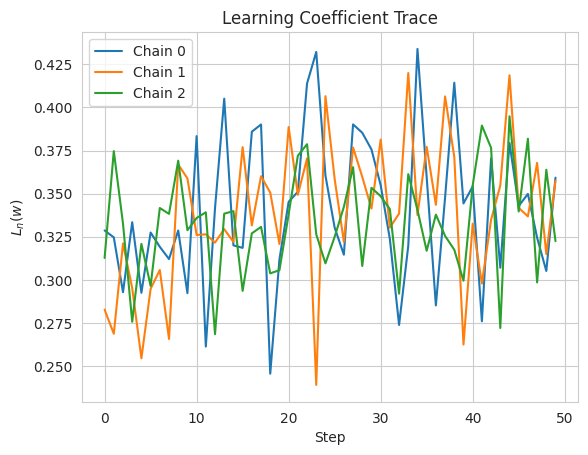

Chain 2: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


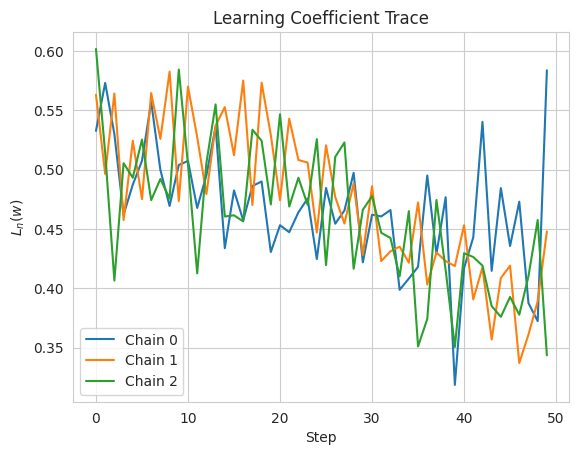

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 5e-7
sgnht_num_chains = 3
sgnht_num_draws = 50
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_cnn1, rlct_estimates_sgnht_cnn1 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

Chain 9: 100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


929.3819708589175 -188.03796626465657


Chain 9: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]

2398.6101932282063 33.81449754950835


### CNN2

In [ ]:
models_rlct = models_cnn2
criterion = nn.CrossEntropyLoss()
train_loader_rlct = noisy_train_loader
train_data_rlct = noisy_train_data

Chain 2: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


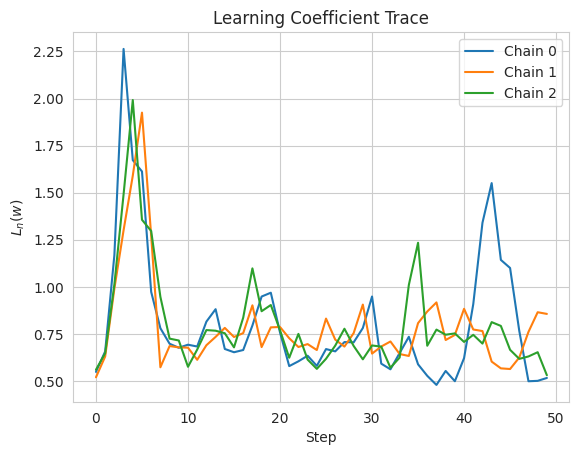

Chain 2: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


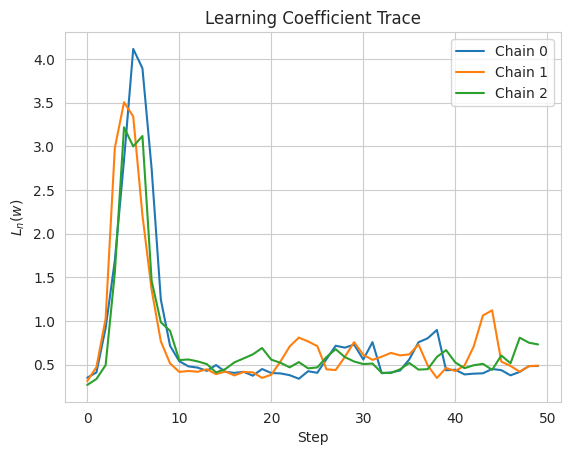

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 50
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


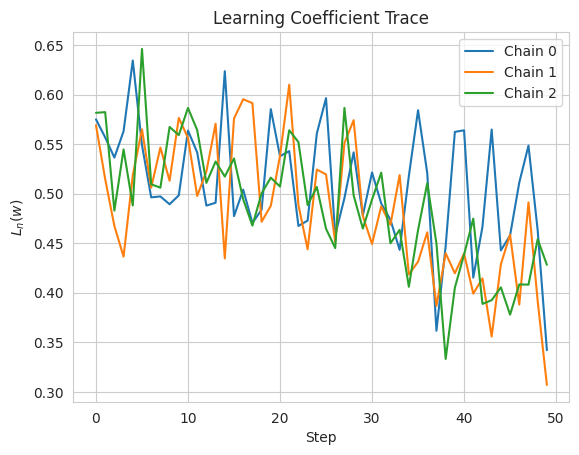

Chain 2: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


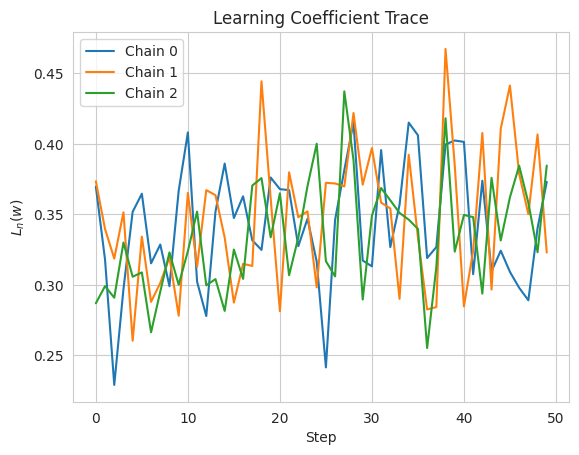

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 5e-7
sgnht_num_chains = 3
sgnht_num_draws = 50
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_cnn2, rlct_estimates_sgnht_cnn2 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

### AE1

In [ ]:
models_rlct = models_ae1
criterion = nn.MSELoss()
train_loader_rlct = train_loader
train_data_rlct = train_data

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 50
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 5e-7
sgnht_num_chains = 3
sgnht_num_draws = 50
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_ae1, rlct_estimates_sgnht_ae1 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

### AE2

In [ ]:
models_rlct = models_ae2
criterion = nn.MSELoss()
train_loader_rlct = noisy_train_loader
train_data_rlct = noisy_train_data

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 50
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 5e-7
sgnht_num_chains = 3
sgnht_num_draws = 50
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_ae2, rlct_estimates_sgnht_ae2 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

## Visualising Results

### Plotting Function

In [ ]:
def plot_graph(train_losses, test_losses, rlct_estimates_sgnht, rlct_estimates_sgld, title):

    epochs = range(1, len(train_losses) + 1) # So we start at epoch 1 instead of epoch zero

    sns.set_style("whitegrid")

    fig, ax1 = plt.subplots()

    # Set labels and title
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=PRIMARY)
    fig.suptitle(title)

    # Plot train and test losses
    ax1.plot(epochs, train_losses, label="Train Loss", color=PRIMARY, marker='o', markersize=8)
    ax1.plot(epochs, test_losses, label="Test Loss", color=PRIMARY_LIGHT, marker='o', markersize=8)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax1.legend(loc="lower left")

    # Create a second y-axis for the RLCT estimates
    ax2 = ax1.twinx()
    ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
    ax2.plot(epochs, rlct_estimates_sgnht, label="SGNHT", color=SECONDARY, marker='o', markersize=8)
    ax2.plot(epochs, rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT, marker='o', markersize=8)
    ax2.tick_params(axis="y", labelcolor=SECONDARY)
    ax2.legend(loc="center right")

    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()


### MLPs

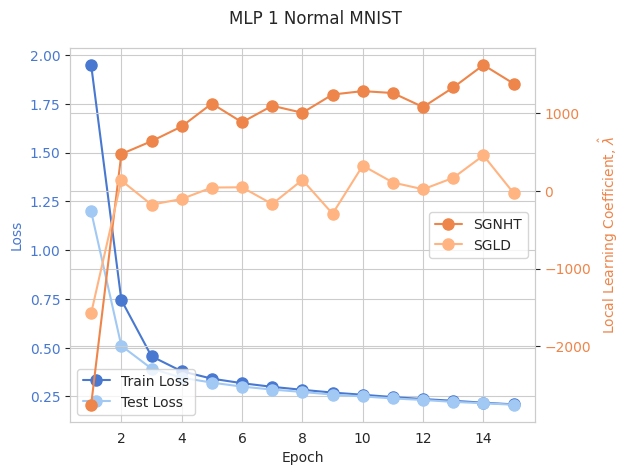

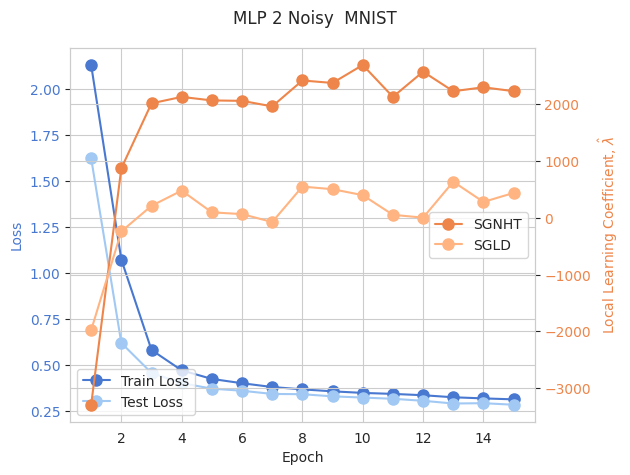

In [ ]:
plot_graph(train_losses_mlp1, test_losses_mlp1, rlct_estimates_sgnht_mlp1, rlct_estimates_sgld_mlp1, "MLP 1 Normal MNIST")
plot_graph(train_losses_mlp2, test_losses_mlp2, rlct_estimates_sgnht_mlp2, rlct_estimates_sgld_mlp2, "MLP 2 Noisy  MNIST")

# RLCT SGLD is not tuned right here so I can't make comments on the results yet

### CNNs

In [ ]:
plot_graph(train_losses_cnn1, test_losses_cnn1, rlct_estimates_sgnht_cnn1, rlct_estimates_sgld_cnn1, "CNN 1 Normal MNIST")
plot_graph(train_losses_cnn2, test_losses_cnn2, rlct_estimates_sgnht_cnn2, rlct_estimates_sgld_cnn2, "CNN 2 Noisy  MNIST")

### AEs

In [ ]:
plot_graph(train_losses_ae1, test_losses_ae1, rlct_estimates_sgnht_ae1, rlct_estimates_sgld_ae1, "AE 1 Normal MNIST")
plot_graph(train_losses_ae2, test_losses_ae2, rlct_estimates_sgnht_ae2, rlct_estimates_sgld_ae2, "AE 2 Noisy  MNIST")